In [1]:
import numpy
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import ipykernel
import subprocess
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# import gym

In [2]:
print(numpy.version.version)
print(ipykernel.__version__)
tf.config.list_physical_devices()


1.23.3
6.15.2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# My personal highscore for that level

In [ ]:
highscore = {"commands":[{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":4,"rotation":-43},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":3,"rotation":-22},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":4,"rotation":-5},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":3,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0},{"power":4,"rotation":0}],"score":421}

In [ ]:
commands = []
for kv in highscore["commands"]:
  power = kv['power']
  rotation = kv['rotation']
  commands.append(f"{rotation} {power}")

commands[:5]

In [5]:
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [6]:
def play(proc, seed, commands):
  # protocol:
  # Enter seed:
  # --> 42
  # Level: 2-3
  # 3 (num_landing_coords)
  # 0 100
  # 1000 500
  # 6999 800

  # loop:
  # receive: json-dump of current state
  # send: 0 0

  def is_done(state):
    return state["isCrashed"] or state["isLanded"] or state["isOffLimits"] or state["isOutOfFuel"] 


  line = proc.stdout.readline()
  if ("seed" not in line):
    raise ValueError(f"expected prompt to enter seed. Was '{line}'")
  else:
    proc.stdin.writelines([f"{seed}\n"])


  replay_commands = deque(commands)
  level_name = proc.stdout.readline()
  # print(f"Level: {level_name}")
  num_landing_coords = int(proc.stdout.readline())
  landing_coords = []
  states = []
  
  


  for _ in range(num_landing_coords):
    landing_coords.append(proc.stdout.readline())

  initial_state = json.loads(proc.stdout.readline())
  states.append(initial_state)

  # print(f"num_landing_coords: {num_landing_coords}")
  # print(f"landing_coords: {landing_coords}")
  # print(initial_state)

  poll = proc.poll()
  while poll is None and len(replay_commands) > 0:
    # print("sending command")
    command = replay_commands.popleft()
    proc.stdin.writelines([f"{command}\n"])
    # print(f'command "{command}" sent')
    
    new_state = json.loads(proc.stdout.readline())
    states.append(new_state)

    if is_done(new_state):
      break

  return level_name, landing_coords, states

# fullopt

In [7]:
%%time
node_path = "/usr/local/bin/node"
script_path = "../cli/target/scala-2.13/cli-opt/main.js"
proc = subprocess.Popen([node_path, script_path], bufsize=1, stderr=subprocess.PIPE, stdout=subprocess.PIPE, stdin=subprocess.PIPE, text=True)
seed = 42
level_name, landing_coords, states = play(proc, seed, commands)
proc.kill()

CPU times: user 6.6 ms, sys: 8.17 ms, total: 14.8 ms
Wall time: 264 ms


In [10]:
json_ary = json.dumps(states)
df = pd.read_json(json_ary)
df

,collisionDistanceOnCurrentTrajectory,distanceLandingArea,fuel,hSpeed,horizontalDistanceLandingArea,isCrashed,isLanded,isOffLimits,isOutOfFuel,landing-distance-0,landing-distance-100,landing-distance-25,landing-distance-50,landing-distance-75,landing-path-free-0,landing-path-free-100,landing-path-free-25,landing-path-free-50,landing-path-free-75,power,radar-maybe-intersection-distance--10,radar-maybe-intersection-distance--15,radar-maybe-intersection-distance--20,radar-maybe-intersection-distance--25,radar-maybe-intersection-distance--30,radar-maybe-intersection-distance--35,radar-maybe-intersection-distance--40,radar-maybe-intersection-distance--45,radar-maybe-intersection-distance--5,radar-maybe-intersection-distance--50,radar-maybe-intersection-distance--55,radar-maybe-intersection-distance--60,radar-maybe-intersection-distance--65,radar-maybe-intersection-distance--70,radar-maybe-intersection-distance--75,radar-maybe-intersection-distance--80,radar-maybe-intersection-distance--85,radar-maybe-intersection-distance--90,radar-maybe-intersection-distance-0,radar-maybe-intersection-distance-10,radar-maybe-intersection-distance-100,radar-maybe-intersection-distance-105,radar-maybe-intersection-distance-110,radar-maybe-intersection-distance-115,radar-maybe-intersection-distance-120,radar-maybe-intersection-distance-125,radar-maybe-intersection-distance-130,radar-maybe-intersection-distance-135,radar-maybe-intersection-distance-140,radar-maybe-intersection-distance-145,radar-maybe-intersection-distance-15,radar-maybe-intersection-distance-150,radar-maybe-intersection-distance-155,radar-maybe-intersection-distance-160,radar-maybe-intersection-distance-165,radar-maybe-intersection-distance-170,radar-maybe-intersection-distance-175,radar-maybe-intersection-distance-180,radar-maybe-intersection-distance-185,radar-maybe-intersection-distance-190,radar-maybe-intersection-distance-195,radar-maybe-intersection-distance-20,radar-maybe-intersection-distance-200,radar-maybe-intersection-distance-205,radar-maybe-intersection-distance-210,radar-maybe-intersection-distance-215,radar-maybe-intersection-distance-220,radar-maybe-intersection-distance-225,radar-maybe-intersection-distance-230,radar-maybe-intersection-distance-235,radar-maybe-intersection-distance-240,radar-maybe-intersection-distance-245,radar-maybe-intersection-distance-25,radar-maybe-intersection-distance-250,radar-maybe-intersection-distance-255,radar-maybe-intersection-distance-260,radar-maybe-intersection-distance-265,radar-maybe-intersection-distance-30,radar-maybe-intersection-distance-35,radar-maybe-intersection-distance-40,radar-maybe-intersection-distance-45,radar-maybe-intersection-distance-5,radar-maybe-intersection-distance-50,radar-maybe-intersection-distance-55,radar-maybe-intersection-distance-60,radar-maybe-intersection-distance-65,radar-maybe-intersection-distance-70,radar-maybe-intersection-distance-75,radar-maybe-intersection-distance-80,radar-maybe-intersection-distance-85,radar-maybe-intersection-distance-90,radar-maybe-intersection-distance-95,rotation,vSpeed,verticalDistanceLandingArea,x,y
0,NaN,2832.401808,750,-90.000000,-1000.000000,False,False,False,False,3643.143560,2832.402161,3396.781252,3175.688902,2985.485953,True,True,True,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5107.946831,4527.526893,4093.530130,3862.888615,3760.269880,3690.321013,3650.199891,3459.328877,3235.052357,NaN,3059.956221,2923.951350,2800.630991,2596.213695,2436.891832,2312.576055,2216.377574,2143.524794,2090.714186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90,0.000000,2650.000000,6500.000000,2800.000000
1,NaN,2800.102845,749,-90.965926,-909.517037,False,False,False,False,3580.380180,2800.103169,3339.552701,3125.276227,2943.355229,True,True,True,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5053.044

In [11]:
level_name

'Level: 2-3\n'

(0.0, 3000.0)

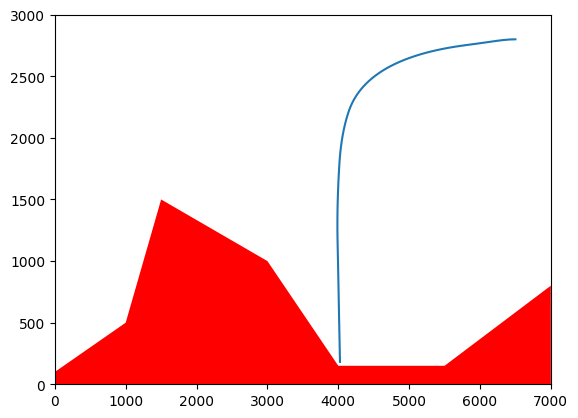

In [12]:
coordinates = df[['x', 'y']].to_numpy()
landing_coordinates = np.array([list(map(int, line.split(' '))) for line in landing_coords] + [[7000, 0], [0, 0]])
poly = Polygon(landing_coordinates, facecolor = 'r')

fig,ax = plt.subplots()
ax.add_patch(poly)
ax.plot(coordinates[:,0], coordinates[:,1]) 
ax.set_xlim([0,7000])
ax.set_ylim([0,3000])
   

## Stesstest 100 games
all same seed and the same commands from the highscore path of that level

In [16]:
%%time
import time

proc = subprocess.Popen([node_path, script_path], bufsize=1, stderr=subprocess.PIPE, stdout=subprocess.PIPE, stdin=subprocess.PIPE, text=True)
seed = 42

n = 100

run_times = []

start = time.time()
for i in range(n):
  s = time.time()
  _ = play(proc, seed, commands)
  e = time.time()
  run_times.append([i, (e-s)*1000])

end = time.time()

run_times = np.array(run_times)

elapsed = (end - start) * 1000
print(f"total: {elapsed:.3f}ms")
print(f"n = {n}")
print(f"avg = {elapsed / n:.3f}ms")
proc.kill()


total: 4921.091ms
n = 100
avg = 49.211ms
CPU times: user 412 ms, sys: 64.9 ms, total: 477 ms
Wall time: 4.93 s


## looks like hotspot optimization in node vm

Text(0.5, 1.0, 'runtime over first 100 runs')

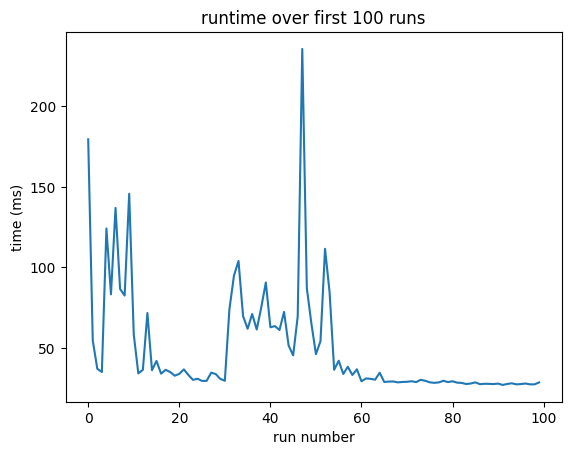

In [17]:
fig,ax = plt.subplots()
display_lim = n
ax.plot(run_times[:display_lim,0], run_times[:display_lim,1])
ax.set_xlabel('run number')
ax.set_ylabel('time (ms)')
ax.set_title(f'runtime over first {display_lim} runs')